In [12]:
import numpy as np
import time
import psutil
from collections import defaultdict
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Naive KNN using brute force search
class NaiveKNN:
    def __init__(self, k):
        self.k = k
    
    def fit(self, X):
        self.X = X
    
    def query(self, query_point):
        distances = [distance.euclidean(query_point, x) for x in self.X]
        nearest_indices = np.argsort(distances)[:self.k]
        return nearest_indices

# KD-Tree KNN
class KDTKNN:
    def __init__(self, k):
        self.k = k
        self.knn = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
    
    def fit(self, X):
        self.knn.fit(X)
    
    def query(self, query_point):
        _, indices = self.knn.kneighbors([query_point])
        return indices[0]

# LSH-based KNN
class LSHKNN:
    def __init__(self, k, num_hash_tables=5, hash_size=10, input_dim=2, seed=42):
        self.k = k
        self.num_hash_tables = num_hash_tables
        self.hash_size = hash_size
        self.input_dim = input_dim
        self.hash_tables = [defaultdict(list) for _ in range(num_hash_tables)]
        np.random.seed(seed)
        self.random_vectors = [np.random.randn(hash_size, input_dim) for _ in range(num_hash_tables)]
    
    def _hash(self, vector, random_vector):
        return ''.join(['1' if np.dot(vector, rv) > 0 else '0' for rv in random_vector])

    def fit(self, X):
        self.data = X
        for i, x in enumerate(X):
            for table_idx in range(self.num_hash_tables):
                hash_code = self._hash(x, self.random_vectors[table_idx])
                self.hash_tables[table_idx][hash_code].append(i)
    
    def query(self, query_point):
        candidates = set()
        for table_idx in range(self.num_hash_tables):
            hash_code = self._hash(query_point, self.random_vectors[table_idx])
            if hash_code in self.hash_tables[table_idx]:
                candidates.update(self.hash_tables[table_idx][hash_code])
        
        if not candidates:
            # No candidates found, return a default label index (e.g., 0)
            return [0]  # You can use a more suitable default based on your dataset

        candidate_list = list(candidates)
        distances = [(i, distance.euclidean(self.data[i], query_point)) for i in candidate_list]
        distances.sort(key=lambda x: x[1])
        return [i for i, _ in distances[:self.k]]

# Generate dataset
def generate_dataset(N, D, centers=5, random_state=42):
    X, _ = make_blobs(n_samples=N, n_features=D, centers=centers, random_state=random_state)
    return X

# Function to measure memory usage
def measure_memory(model, fit_func, *args, **kwargs):
    process = psutil.Process()
    mem_before = process.memory_info().rss
    fit_func(*args, **kwargs)
    mem_after = process.memory_info().rss
    return (mem_after - mem_before) * 1e6  # Convert memory difference to KB

# Comparison function including training and testing time and memory usage
def compare_knn_methods(N, D, k=5, num_trials=10):
    # Generate dataset
    X = generate_dataset(N, D)
    query_point = X[np.random.randint(N)]
    
    # Initialize variables to accumulate times and memory
    naive_train_times, naive_test_times = [], []
    kdtree_train_times, kdtree_test_times = [], []
    lsh_train_times, lsh_test_times = [], []
    naive_memory, kdtree_memory, lsh_memory = 0, 0, 0
    
    # Run multiple trials
    for _ in range(num_trials):
        # Naive KNN
        naive_knn = NaiveKNN(k)
        start_time = time.time()
        naive_memory = measure_memory(naive_knn, naive_knn.fit, X)
        naive_train_times.append(time.time() - start_time)
        
        start_time = time.time()
        naive_neighbors = naive_knn.query(query_point)
        naive_test_times.append(time.time() - start_time)
        
        # KD-Tree KNN
        kdt_knn = KDTKNN(k)
        start_time = time.time()
        kdtree_memory = measure_memory(kdt_knn, kdt_knn.fit, X)
        kdtree_train_times.append(time.time() - start_time)
        
        start_time = time.time()
        kdtree_neighbors = kdt_knn.query(query_point)
        kdtree_test_times.append(time.time() - start_time)
        
        # LSH KNN
        lsh_knn = LSHKNN(k, num_hash_tables=5, hash_size=10, input_dim=D)
        start_time = time.time()
        lsh_memory = measure_memory(lsh_knn, lsh_knn.fit, X)
        lsh_train_times.append(time.time() - start_time)
        
        start_time = time.time()
        lsh_neighbors = lsh_knn.query(query_point)
        lsh_test_times.append(time.time() - start_time)
    
    # Calculate missed neighbors for approximate methods (using last run)
    missed_neighbors_kdtree = len(set(naive_neighbors) - set(kdtree_neighbors))
    missed_neighbors_lsh = len(set(naive_neighbors) - set(lsh_neighbors))
    
    return {
        'N': N,
        'D': D,
        'naive_train_time': np.mean(naive_train_times),
        'naive_test_time': np.mean(naive_test_times),
        'naive_memory': naive_memory,
        'kdtree_train_time': np.mean(kdtree_train_times),
        'kdtree_test_time': np.mean(kdtree_test_times),
        'kdtree_memory': kdtree_memory,
        'lsh_train_time': np.mean(lsh_train_times),
        'lsh_test_time': np.mean(lsh_test_times),
        'lsh_memory': lsh_memory,
        'missed_neighbors_kdtree': missed_neighbors_kdtree,
        'missed_neighbors_lsh': missed_neighbors_lsh,
        'naive_neighbors': naive_neighbors,
        'kdtree_neighbors': kdtree_neighbors,
        'lsh_neighbors': lsh_neighbors
    }


# Experiment with multiple dataset sizes and dimensions
N_values = [100, 500, 1000, 10000]  # Example sizes
D_values = [2, 5, 10, 50]         # Example dimensions
k = 5                         # Number of nearest neighbors

results = []
for N in N_values:
    for D in D_values:
        result = compare_knn_methods(N, D, k=k, num_trials=10)
        results.append(result)
        print(f"Results for N={N}, D={D}:")
        print(f"Naive Train Time: {result['naive_train_time']:.4f}s, Test Time: {result['naive_test_time']:.4f}s, Memory: {result['naive_memory'] / 1e6:.2f} MB")
        print(f"KD-Tree Train Time: {result['kdtree_train_time']:.4f}s, Test Time: {result['kdtree_test_time']:.4f}s, Memory: {result['kdtree_memory'] / 1e6:.2f} MB")
        print(f"LSH Train Time: {result['lsh_train_time']:.4f}s, Test Time: {result['lsh_test_time']:.4f}s, Memory: {result['lsh_memory'] / 1e6:.2f} MB")
        print(f"Missed Neighbors (KD-Tree): {result['missed_neighbors_kdtree']}/{k}")
        print(f"Missed Neighbors (LSH): {result['missed_neighbors_lsh']}/{k}")
        print()


Results for N=100, D=2:
Naive Train Time: 0.0000s, Test Time: 0.0014s, Memory: 0.00 MB
KD-Tree Train Time: 0.0004s, Test Time: 0.0011s, Memory: 0.00 MB
LSH Train Time: 0.0043s, Test Time: 0.0003s, Memory: 0.00 MB
Missed Neighbors (KD-Tree): 0/5
Missed Neighbors (LSH): 0/5

Results for N=100, D=5:
Naive Train Time: 0.0000s, Test Time: 0.0000s, Memory: 0.00 MB
KD-Tree Train Time: 0.0000s, Test Time: 0.0001s, Memory: 0.00 MB
LSH Train Time: 0.0061s, Test Time: 0.0007s, Memory: 0.00 MB
Missed Neighbors (KD-Tree): 0/5
Missed Neighbors (LSH): 0/5

Results for N=100, D=10:
Naive Train Time: 0.0000s, Test Time: 0.0009s, Memory: 0.00 MB
KD-Tree Train Time: 0.0000s, Test Time: 0.0009s, Memory: 0.00 MB
LSH Train Time: 0.0096s, Test Time: 0.0001s, Memory: 0.00 MB
Missed Neighbors (KD-Tree): 0/5
Missed Neighbors (LSH): 0/5

Results for N=100, D=50:
Naive Train Time: 0.0000s, Test Time: 0.0012s, Memory: 0.00 MB
KD-Tree Train Time: 0.0005s, Test Time: 0.0010s, Memory: 0.00 MB
LSH Train Time: 0.0082s,

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time_vs_N(results, method_names):
    """Plot training and testing time as a function of dataset size N."""
    Ns = sorted(set(result['N'] for result in results))
    for method in method_names:
        train_times = [np.mean([result[f"{method}_train_time"] for result in results if result['N'] == N]) for N in Ns]
        test_times = [np.mean([result[f"{method}_test_time"] for result in results if result['N'] == N]) for N in Ns]

        plt.plot(Ns, train_times, label=f"{method} Train Time")
        plt.plot(Ns, test_times, '--', label=f"{method} Test Time")

    plt.xlabel("Dataset Size (N)")
    plt.ylabel("Time (seconds)")
    plt.title("Training and Testing Time vs Dataset Size (N)")
    plt.legend()
    plt.show()

def plot_time_vs_D(results, method_names):
    """Plot training and testing time as a function of dimensionality D."""
    Ds = sorted(set(result['D'] for result in results))
    for method in method_names:
        train_times = [np.mean([result[f"{method}_train_time"] for result in results if result['D'] == D]) for D in Ds]
        test_times = [np.mean([result[f"{method}_test_time"] for result in results if result['D'] == D]) for D in Ds]

        plt.plot(Ds, train_times, label=f"{method} Train Time")
        plt.plot(Ds, test_times, '--', label=f"{method} Test Time")

    plt.xlabel("Dimensionality (D)")
    plt.ylabel("Time (seconds)")
    plt.title("Training and Testing Time vs Dimensionality (D)")
    plt.legend()
    plt.show()

def plot_missed_neighbors(results):
    """Plot missed neighbors for KD-Tree and LSH compared to Naive KNN in 2D."""
    missed_kdtree = [result['missed_neighbors_kdtree'] for result in results if result['D'] == 2]
    missed_lsh = [result['missed_neighbors_lsh'] for result in results if result['D'] == 2]
    Ns = [result['N'] for result in results if result['D'] == 2]

    plt.plot(Ns, missed_kdtree, label="KD-Tree Missed Neighbors", marker='o')
    plt.plot(Ns, missed_lsh, label="LSH Missed Neighbors", marker='x')
    plt.xlabel("Dataset Size (N)")
    plt.ylabel("Missed Neighbors")
    plt.title("Missed Neighbors for Approximate KNN Methods in 2D")
    plt.legend()
    plt.show()


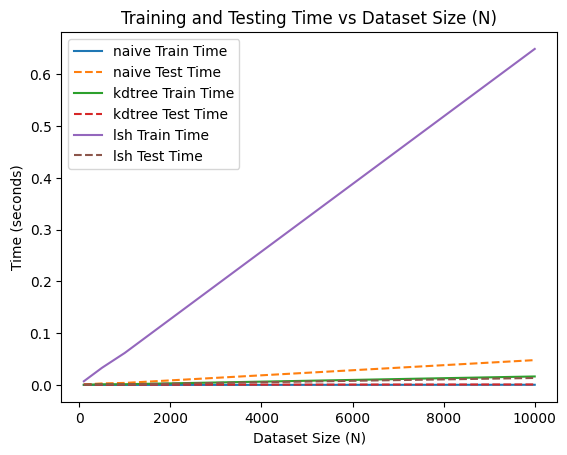

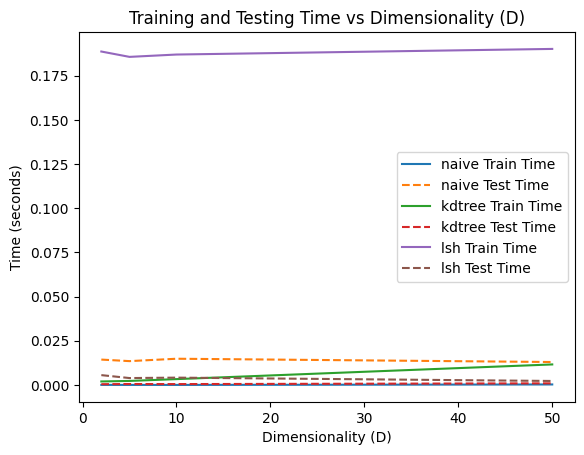

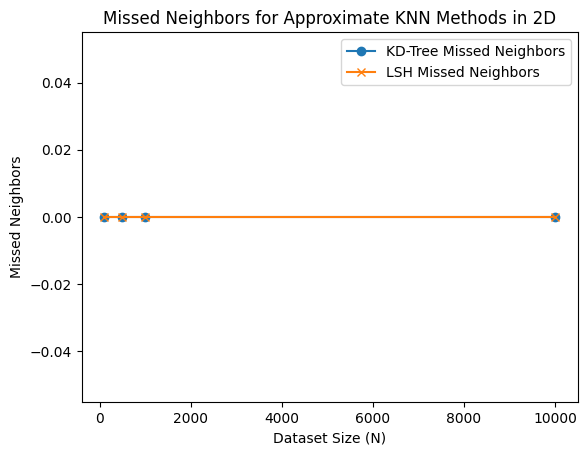

In [14]:
# Example usage
plot_time_vs_N(results, ['naive', 'kdtree', 'lsh'])
plot_time_vs_D(results, ['naive', 'kdtree', 'lsh'])
plot_missed_neighbors(results)

In [17]:
def plot_partitions_and_neighbors(X, query_point, naive_knn, kdt_knn, lsh_knn, k=5):
    """Visualize the partitions and missed neighbors in a 2D space."""
    # Generate a mesh grid to show decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel()]  # Flatten the grid for prediction

    # Default label if no neighbors are found
    default_label = 0

    # Get KNN results for each method on the mesh grid
    naive_labels = np.array([
        naive_knn.query(pt)[0] if len(naive_knn.query(pt)) > 0 else default_label
        for pt in grid_points
    ])
    kdtree_labels = np.array([
        kdt_knn.query(pt)[0] if len(kdt_knn.query(pt)) > 0 else default_label
        for pt in grid_points
    ])
    lsh_labels = np.array([
        lsh_knn.query(pt)[0] if len(lsh_knn.query(pt)) > 0 else default_label
        for pt in grid_points
    ])

    # Reshape the results back to the grid shape
    naive_labels = naive_labels.reshape(xx.shape)
    kdtree_labels = kdtree_labels.reshape(xx.shape)
    lsh_labels = lsh_labels.reshape(xx.shape)

    # Plot decision boundaries
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.contourf(xx, yy, naive_labels, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c='blue', edgecolor='k', label="Data Points")
    plt.scatter(query_point[0], query_point[1], color='red', label="Query Point")
    plt.title("Naive KNN Partitions")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.contourf(xx, yy, kdtree_labels, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c='blue', edgecolor='k', label="Data Points")
    plt.scatter(query_point[0], query_point[1], color='red', label="Query Point")
    plt.title("KD-Tree KNN Partitions")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.contourf(xx, yy, lsh_labels, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c='blue', edgecolor='k', label="Data Points")
    plt.scatter(query_point[0], query_point[1], color='red', label="Query Point")
    plt.title("LSH KNN Partitions")
    plt.legend()

    plt.show()


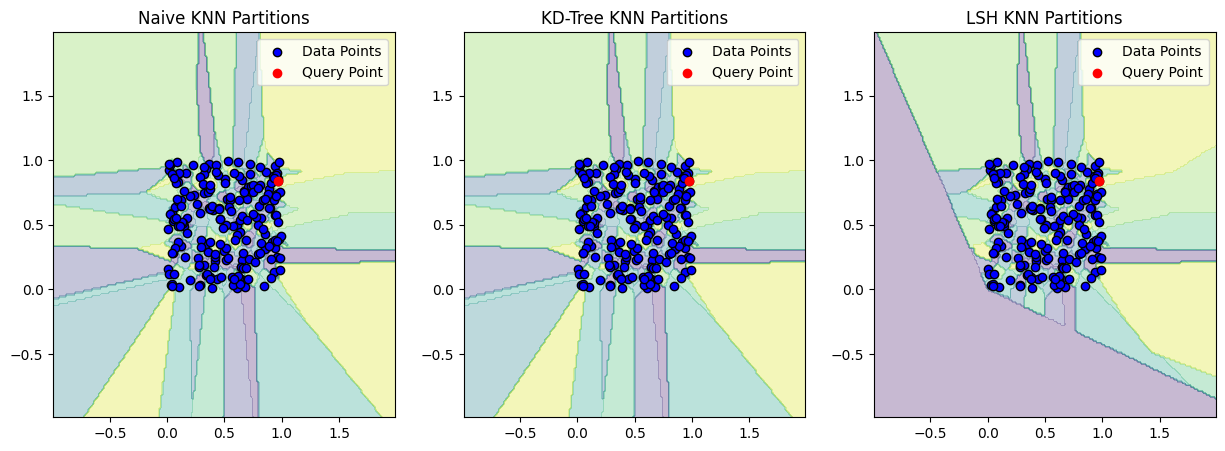

In [18]:
# Generate a 2D dataset with N samples
N = 200  # Number of data points
X = np.random.rand(N, 2)  # Randomly generated data in 2D space

# Generate a random query point from the dataset (for visualization)
query_point = X[np.random.randint(N)]

naive_knn = NaiveKNN(k=5)
kdt_knn = KDTKNN(k=5)
lsh_knn = LSHKNN(k=5)

# Fit the models on the 2D dataset
naive_knn.fit(X)
kdt_knn.fit(X)
lsh_knn.fit(X)

# Now, call the function to plot the partitions
plot_partitions_and_neighbors(X, query_point, naive_knn, kdt_knn, lsh_knn, k=5)
